<a href="https://colab.research.google.com/github/JianHMai/Taxi-Tips-Prediction/blob/SVR/SVR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
#Preprocessing the data
from dateutil import parser
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("TaxiTrip2021Subset1.csv")

data = data.drop(columns='Trip End Timestamp')
data = data.rename(columns = {'Trip Start Timestamp' : 'time'})

data["Payment Type"] = LabelEncoder().fit_transform(data["Payment Type"])
data["Company"] = LabelEncoder().fit_transform(data["Company"])

for i in range(len(data)):
  data.at[i, "time"] = parser.parse(data.iloc[i,0]).time().hour

train = data.sample(frac=0.8)
test = data.drop(train.index).sample(frac=1.0)

In [3]:
data.corr()

,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
Trip Seconds,1.000000,0.393389,0.178252,0.088999,0.510789,0.117294,NaN,0.034911,0.463501,0.168726,-0.035323,-0.017790,-0.176138,-0.050536,-0.071410
Trip Miles,0.393389,1.000000,0.399845,0.152593,0.801052,0.307556,NaN,0.099237,0.762608,0.168517,-0.136748,-0.014256,-0.407754,-0.083993,-0.121398
Pickup Community Area,0.178252,0.399845,1.000000,0.277298,0.426233,0.253540,NaN,0.161970,0.453364,0.060564,0.056871,-0.227303,-0.526537,-0.186523,-0.067976
Dropoff Community Area,0.088999,0.152593,0.277298,1.000000,0.202908,-0.047602,NaN,0.018139,0.168979,0.184160,0.010925,-0.282264,0.037561,-0.460824,-0.209213
Fare,0.510789,0.801052,0.426233,0.202908,1.000000,0.314545,NaN,0.094575,0.930305,0.236111,-0.028909,-0.050392,-0.403102,-0.118281,-0.149868
Tips,0.117294,0.307556,0.253540,-0.047602,0.314545,1.000000,NaN,0.129355,0.476995,-0.125401,0.049107,0.175602,-0.413662,0.124380,-0.101917
Tolls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extras,0.034911,0.099237,0.161970,0.018139,0.094575,0.129355,NaN,1.000000,0.415786,-0.074645,0.037750,0.074336,-0.239953,0.049831,-0.098770
Trip Total,0.463501,0.762608,0.453364,0.168979,0.930305,0.476995,NaN,0.415786,1.000000,0.156727,-0.007986,0.011224,-0.486300,-0.062762,-0.175536
Payment Type,0.168726,0.168517,0.060564,0.184160,0.236111,-0.125401,NaN,-0.074645,0.156727,1.000000,-0.024071,-0.259636,0.165063,-0.274322,0.104222


In [4]:
#Original
trainX = train[['Trip Seconds', 'Trip Miles', 'Fare']]
trainY = train['Tips']
testX = test[['Trip Seconds', 'Trip Miles', 'Fare']]
testY = test['Tips']

In [5]:
#trainX = train[['Trip Miles', 'Fare', 'Trip Total', 'Pickup Centroid Longitude']]
#trainY = train['Tips']
#testX = test[['Trip Miles', 'Fare', 'Trip Total', 'Pickup Centroid Longitude']]
#testY = test['Tips']

In [6]:
svr_clf = make_pipeline(StandardScaler(), SVR())
svr_clf.fit(trainX, trainY)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [7]:
svr_predY = svr_clf.predict(testX)
result = pd.DataFrame({"Fare": testX['Fare'], "Y Tips": testY, "Predicted": np.round(svr_predY,2)})
result

,Fare,Y Tips,Predicted
337,6.50,1.30,0.10
6633,8.00,0.00,0.10
6680,10.50,0.00,0.10
3687,8.75,0.00,0.10
5291,7.50,3.00,0.10
...,...,...,...
2621,3.25,0.00,0.10
3941,29.25,0.00,-0.01
4780,36.00,0.00,0.30
8247,13.25,1.99,0.10


In [8]:
rmse = mean_squared_error(testY, svr_predY, squared=False)
print("RMSE: " + "{:.2f}".format(rmse))

RMSE: 2.59


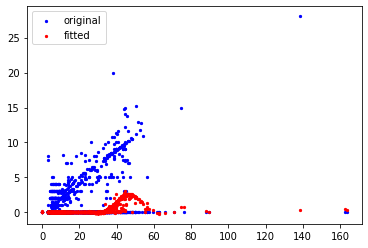

In [9]:
plt.scatter(testX['Fare'], testY, s=5, color="blue", label="original")
plt.scatter(testX['Fare'], svr_predY, s=5, color="red", label="fitted")
plt.legend()
plt.show()

In [10]:
#feature selection
from functools import partial
from sklearn.feature_selection import SelectKBest, mutual_info_regression

ftrainX = train.loc[:, data.columns != 'Tips']
ftrainY = train['Tips']

select = SelectKBest(mutual_info_regression, k=4).fit(ftrainX, ftrainY)
cols = select.get_support(indices=True)

ftrainX = ftrainX.iloc[:, cols]
ftestX = test.loc[:, data.columns != 'Tips'].iloc[:, cols]
ftestY = test['Tips']

In [11]:
ftrainX

,Trip Miles,Fare,Trip Total,Payment Type
5707,0.00,5.25,5.25,0
6914,7.19,21.50,21.50,5
123,0.00,6.75,6.75,0
7812,8.60,25.50,25.50,5
616,13.48,40.77,40.77,0
...,...,...,...,...
7789,1.40,7.50,9.50,1
7046,2.86,10.75,10.75,0
6594,5.20,15.75,19.75,0
611,9.53,27.75,27.75,5


In [12]:
fsvr_clf = make_pipeline(StandardScaler(), SVR())
fsvr_clf.fit(ftrainX, ftrainY)

fsvr_predY = fsvr_clf.predict(ftestX)
result = pd.DataFrame({"Fare": ftestX['Fare'], "Y Tips": ftestY, "Predicted": np.round(fsvr_predY,2)})
result

,Fare,Y Tips,Predicted
337,6.50,1.30,1.72
6633,8.00,0.00,-0.10
6680,10.50,0.00,-0.08
3687,8.75,0.00,-0.10
5291,7.50,3.00,2.19
...,...,...,...
2621,3.25,0.00,0.07
3941,29.25,0.00,0.01
4780,36.00,0.00,0.06
8247,13.25,1.99,2.54


In [13]:
rmse = mean_squared_error(testY, fsvr_predY, squared=False)
print("RMSE: " + "{:.2f}".format(rmse))

RMSE: 1.10


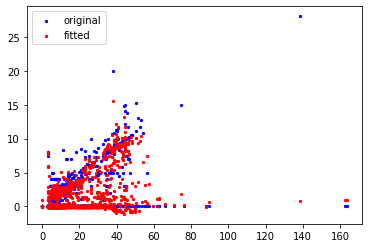

In [14]:
plt.scatter(testX['Fare'], testY, s=5, color="blue", label="original")
plt.scatter(testX['Fare'], fsvr_predY, s=5, color="red", label="fitted")
plt.legend()
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param = {'svr__kernel' : ['rbf', 'sigmoid'], 'svr__degree' : [2, 3], 'svr__C' : [19, 20] }

grid_clf = GridSearchCV(estimator = svr_clf, param_grid = param, scoring = 'r2')

grid_clf.fit(trainX, trainY)

for param in grid_clf.best_params_:
  print("{0}:\t{1}".format(param,grid_clf.best_params_[param]))

svr__C:	20
svr__degree:	2
svr__kernel:	rbf


In [16]:
nsvr_clf = make_pipeline(StandardScaler(), SVR(degree=2, C=20))
nsvr_clf.fit(ftrainX, ftrainY)

nsvr_predY = nsvr_clf.predict(ftestX)
result = pd.DataFrame({"Fare": ftestX['Fare'], "Y Tips": ftestY, "Predicted": np.round(nsvr_predY,2)})
result

,Fare,Y Tips,Predicted
337,6.50,1.30,1.37
6633,8.00,0.00,-0.08
6680,10.50,0.00,-0.10
3687,8.75,0.00,-0.10
5291,7.50,3.00,2.50
...,...,...,...
2621,3.25,0.00,-0.04
3941,29.25,0.00,-0.07
4780,36.00,0.00,-0.07
8247,13.25,1.99,1.98


In [17]:
rmse = mean_squared_error(testY, nsvr_predY, squared=False)
print("RMSE: " + "{:.2f}".format(rmse))

RMSE: 0.96


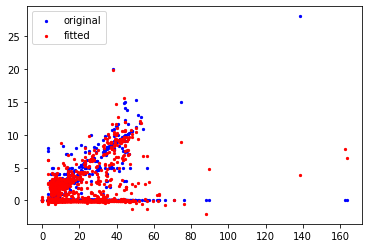

In [18]:
plt.scatter(testX['Fare'], testY, s=5, color="blue", label="original")
plt.scatter(testX['Fare'], nsvr_predY, s=5, color="red", label="fitted")
plt.legend()
plt.show()

In [19]:
result = pd.DataFrame({"Trip Fare": testX['Fare'], "Actual Tips": testY, "Original Predicted": np.round(svr_predY,2), "After feature selected": np.round(fsvr_predY,2), "After feature & parameter": np.round(nsvr_predY,2)})
result.sort_values('Actual Tips', ascending=False).head(15)

,Trip Fare,Actual Tips,Original Predicted,After feature selected,After feature & parameter
3170,138.75,28.05,0.32,0.77,3.84
4015,38.00,20.00,0.73,15.56,19.90
1733,50.50,15.25,2.07,10.02,10.40
7676,74.50,15.00,0.75,1.80,8.93
1323,44.75,15.00,0.21,11.72,11.95
5020,43.75,14.78,2.37,13.15,15.53
1603,44.50,14.10,3.02,9.49,10.51
6605,45.50,13.75,2.59,9.19,9.10
6724,51.25,13.00,1.91,9.34,9.33
4600,53.25,12.75,1.59,10.41,11.83


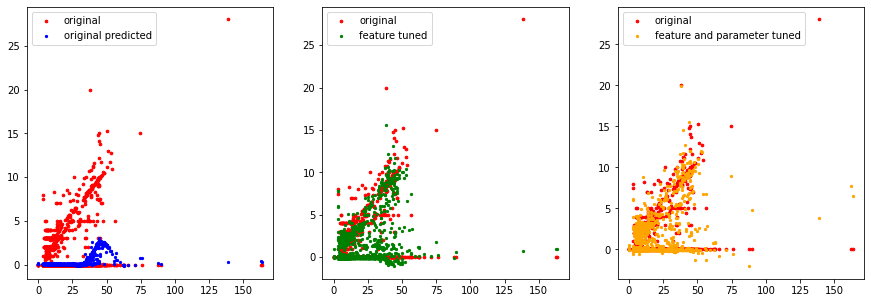

In [20]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.scatter(result['Trip Fare'], result['Actual Tips'], s=7, color="red", label="original")
plt.scatter(result['Trip Fare'], result['Original Predicted'], s=5, color="blue", label="original predicted")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(result['Trip Fare'], result['Actual Tips'], s=7, color="red", label="original")
plt.scatter(result['Trip Fare'], result['After feature selected'], s=5, color="green", label="feature tuned")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(result['Trip Fare'], result['Actual Tips'], s=7, color="red", label="original")
plt.scatter(result['Trip Fare'], result['After feature & parameter'], s=5, color="orange", label="feature and parameter tuned")
plt.legend()

plt.show()